In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_BN(conv_num=1):
    init_channel = 32
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel*(2**int((i+1)/3))), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(BatchNormalization())
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 32)         128       
_________________________________________________________________
activation (Activation)      (None, 16000, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512000)            0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 512000)            2048000   
_________________________________________________________________
dense (Dense)                (None, 16)                8192016   
Total params: 10,240,336
Trainable params: 9,216,272
Non-trainable par

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_15 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 32)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_44 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_37 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 32)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8937 - acc: 0.4471
Epoch 00001: val_loss improved from inf to 1.63084, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_BN_4_conv_checkpoint/001-1.6308.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 1.8936 - acc: 0.4471 - val_loss: 1.6308 - val_acc: 0.4917
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1001 - acc: 0.6705
Epoch 00002: val_loss improved from 1.63084 to 1.32516, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_BN_4_conv_checkpoint/002-1.3252.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 1.1002 - acc: 0.6705 - val_loss: 1.3252 - val_acc: 0.6094
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7346 - acc: 0.7742
Epoch 00003: val_loss did not improve from 1.32516
36805/36805 [===

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0347 - acc: 0.9931
Epoch 00029: val_loss did not improve from 1.29377
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0348 - acc: 0.9931 - val_loss: 1.9095 - val_acc: 0.6511
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9959
Epoch 00030: val_loss did not improve from 1.29377
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0270 - acc: 0.9959 - val_loss: 1.9847 - val_acc: 0.6420
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0403 - acc: 0.9921
Epoch 00031: val_loss did not improve from 1.29377
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0407 - acc: 0.9920 - val_loss: 1.9581 - val_acc: 0.6427
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0288 - acc: 0.9949
Epoch 00032: val_loss did not improve from 1.29377
36805/36805 [===========

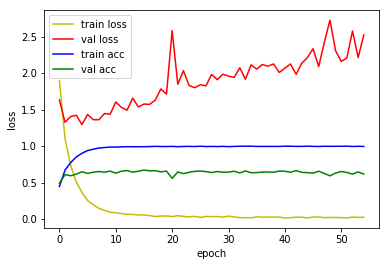

4815/4815 [==============================] - 3s 522us/sample - loss: 1.4314 - acc: 0.6021
Loss: 1.4313814536309564 Accuracy: 0.6020768

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8451 - acc: 0.4377
Epoch 00001: val_loss improved from inf to 1.63746, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_BN_5_conv_checkpoint/001-1.6375.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.8450 - acc: 0.4377 - val_loss: 1.6375 - val_acc: 0.4910
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1640 - acc: 0.6478
Epoch 00002: val_loss improved from 1.63746 to 1.09634, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_BN_5_conv_checkpoint/002-1.0963.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 1.1641 - acc: 0.6478 - val_loss: 1.0963 - val_acc: 0.6683
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0560 - acc: 0.9920
Epoch 00028: val_loss did not improve from 0.91514
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0560 - acc: 0.9920 - val_loss: 1.0940 - val_acc: 0.7529
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0512 - acc: 0.9931
Epoch 00029: val_loss did not improve from 0.91514
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0513 - acc: 0.9930 - val_loss: 1.1220 - val_acc: 0.7547
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0493 - acc: 0.9926
Epoch 00030: val_loss did not improve from 0.91514
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0494 - acc: 0.9925 - val_loss: 1.3020 - val_acc: 0.7156
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0591 - acc: 0.9899
Epoch 00031: val_loss did not improve from 0.91514
36805/36805 [===========


1D_CNN_custom_3_ch_32_BN_5_conv Model


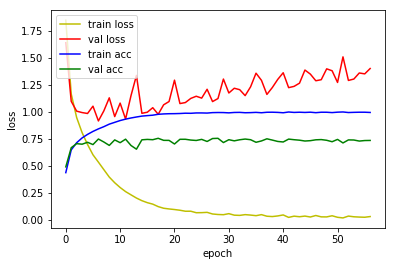

4815/4815 [==============================] - 3s 558us/sample - loss: 0.9976 - acc: 0.7020
Loss: 0.9975839767871988 Accuracy: 0.701973

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8809 - acc: 0.4211
Epoch 00001: val_loss improved from inf to 1.59712, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_BN_6_conv_checkpoint/001-1.5971.hdf5
36805/36805 [==============================] - 55s 2ms/sample - loss: 1.8809 - acc: 0.4211 - val_loss: 1.5971 - val_acc: 0.4729
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2201 - acc: 0.6260
Epoch 00002: val_loss improved from 1.59712 to 1.06003, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_BN_6_conv_checkpoint/002-1.0600.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 1.2200 - acc: 0.6260 - val_loss: 1.0600 - val_acc: 0.6834
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1602 - acc: 0.9582
Epoch 00027: val_loss did not improve from 0.52797
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1602 - acc: 0.9582 - val_loss: 0.5749 - val_acc: 0.8430
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1517 - acc: 0.9619
Epoch 00028: val_loss did not improve from 0.52797
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1518 - acc: 0.9619 - val_loss: 0.5754 - val_acc: 0.8418
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1489 - acc: 0.9623
Epoch 00029: val_loss did not improve from 0.52797
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1489 - acc: 0.9622 - val_loss: 0.5697 - val_acc: 0.8507
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1361 - acc: 0.9673
Epoch 00030: val_loss did not improve from 0.52797
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0697 - acc: 0.9832
Epoch 00057: val_loss did not improve from 0.52797
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0697 - acc: 0.9832 - val_loss: 0.6063 - val_acc: 0.8600
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0389 - acc: 0.9935
Epoch 00058: val_loss did not improve from 0.52797
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0390 - acc: 0.9935 - val_loss: 0.6983 - val_acc: 0.8470
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0433 - acc: 0.9916
Epoch 00059: val_loss did not improve from 0.52797
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0434 - acc: 0.9916 - val_loss: 0.6101 - val_acc: 0.8598
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0513 - acc: 0.9895
Epoch 00060: val_loss did not improve from 0.52797
36805/36805 [===========

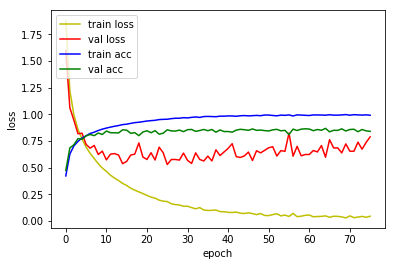

4815/4815 [==============================] - 3s 631us/sample - loss: 0.6205 - acc: 0.8224
Loss: 0.6205333469565165 Accuracy: 0.8224299

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9010 - acc: 0.4200
Epoch 00001: val_loss improved from inf to 1.45277, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_BN_7_conv_checkpoint/001-1.4528.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 1.9009 - acc: 0.4201 - val_loss: 1.4528 - val_acc: 0.5609
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1268 - acc: 0.6646
Epoch 00002: val_loss improved from 1.45277 to 1.15555, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_BN_7_conv_checkpoint/002-1.1555.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 1.1269 - acc: 0.6646 - val_loss: 1.1555 - val_acc: 0.6424
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0982 - acc: 0.9754
Epoch 00025: val_loss improved from 0.29077 to 0.28278, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_BN_7_conv_checkpoint/025-0.2828.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0983 - acc: 0.9754 - val_loss: 0.2828 - val_acc: 0.9248
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0932 - acc: 0.9768
Epoch 00026: val_loss did not improve from 0.28278
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0934 - acc: 0.9767 - val_loss: 0.2981 - val_acc: 0.9171
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0936 - acc: 0.9756
Epoch 00027: val_loss did not improve from 0.28278
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0936 - acc: 0.9756 - val_loss: 0.2982 - val_acc: 0.9175
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss:

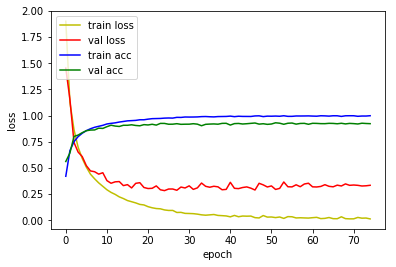

4815/4815 [==============================] - 3s 642us/sample - loss: 0.3374 - acc: 0.9034
Loss: 0.3374249934964462 Accuracy: 0.90342677

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7139 - acc: 0.4824
Epoch 00001: val_loss improved from inf to 1.32595, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_BN_8_conv_checkpoint/001-1.3259.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 1.7139 - acc: 0.4824 - val_loss: 1.3259 - val_acc: 0.5863
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8444 - acc: 0.7524
Epoch 00002: val_loss improved from 1.32595 to 0.66413, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_BN_8_conv_checkpoint/002-0.6641.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.8443 - acc: 0.7524 - val_loss: 0.6641 - val_acc: 0.8022
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0342 - acc: 0.9927
Epoch 00026: val_loss did not improve from 0.18378
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0343 - acc: 0.9926 - val_loss: 0.2265 - val_acc: 0.9352
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0451 - acc: 0.9886
Epoch 00027: val_loss improved from 0.18378 to 0.18331, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_BN_8_conv_checkpoint/027-0.1833.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0451 - acc: 0.9886 - val_loss: 0.1833 - val_acc: 0.9474
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0245 - acc: 0.9961
Epoch 00028: val_loss did not improve from 0.18331
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0247 - acc: 0.9961 - val_loss: 0.2106 - val_acc: 0.9413
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss:

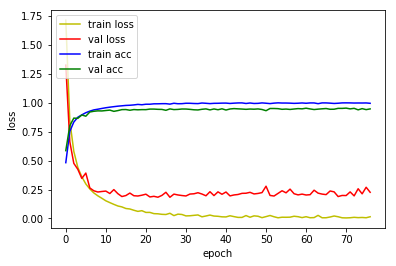

4815/4815 [==============================] - 3s 666us/sample - loss: 0.2575 - acc: 0.9267
Loss: 0.25753685289206657 Accuracy: 0.9266874

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3533 - acc: 0.5842
Epoch 00001: val_loss improved from inf to 0.91334, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_BN_9_conv_checkpoint/001-0.9133.hdf5
36805/36805 [==============================] - 71s 2ms/sample - loss: 1.3533 - acc: 0.5842 - val_loss: 0.9133 - val_acc: 0.7412
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5692 - acc: 0.8300
Epoch 00002: val_loss improved from 0.91334 to 0.41847, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_BN_9_conv_checkpoint/002-0.4185.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.5693 - acc: 0.8299 - val_loss: 0.4185 - val_acc: 0.8751
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0132 - acc: 0.9982
Epoch 00027: val_loss did not improve from 0.17026
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0133 - acc: 0.9982 - val_loss: 0.1826 - val_acc: 0.9497
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0291 - acc: 0.9929
Epoch 00028: val_loss did not improve from 0.17026
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0291 - acc: 0.9929 - val_loss: 0.1926 - val_acc: 0.9469
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0138 - acc: 0.9975
Epoch 00029: val_loss did not improve from 0.17026
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0138 - acc: 0.9975 - val_loss: 0.2424 - val_acc: 0.9411
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0145 - acc: 0.9970
Epoch 00030: val_loss did not improve from 0.17026
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0040 - acc: 0.9996
Epoch 00057: val_loss did not improve from 0.17026
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0041 - acc: 0.9995 - val_loss: 0.2234 - val_acc: 0.9467
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0155 - acc: 0.9960
Epoch 00058: val_loss did not improve from 0.17026
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0155 - acc: 0.9960 - val_loss: 0.2071 - val_acc: 0.9495
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0040 - acc: 0.9994
Epoch 00059: val_loss did not improve from 0.17026
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0042 - acc: 0.9994 - val_loss: 0.1883 - val_acc: 0.9529
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0188 - acc: 0.9946
Epoch 00060: val_loss did not improve from 0.17026
36805/36805 [===========

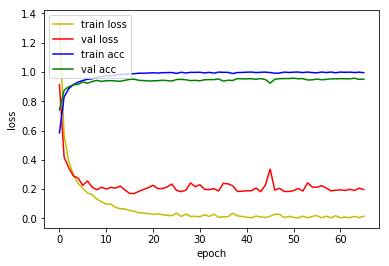

4815/4815 [==============================] - 3s 716us/sample - loss: 0.2286 - acc: 0.9294
Loss: 0.22861972911552228 Accuracy: 0.92938733



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_3_ch_32_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_3_ch_32_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_3_ch_32_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5

4815/4815 [==============================] - 4s 753us/sample - loss: 0.6205 - acc: 0.8224
Loss: 0.6205333469565165 Accuracy: 0.8224299

1D_CNN_custom_3_ch_32_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_72 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_61 (Activation)   (None

4815/4815 [==============================] - 4s 796us/sample - loss: 0.2575 - acc: 0.9267
Loss: 0.25753685289206657 Accuracy: 0.9266874

1D_CNN_custom_3_ch_32_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_89 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_75 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_76 (Activation)   (Non

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_3_ch_32_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5

4815/4815 [==============================] - 4s 911us/sample - loss: 0.9241 - acc: 0.8164
Loss: 0.9240950173430478 Accuracy: 0.8164071

1D_CNN_custom_3_ch_32_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_72 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_61 (Activation)   (None

4815/4815 [==============================] - 4s 916us/sample - loss: 0.2958 - acc: 0.9340
Loss: 0.29577742000946994 Accuracy: 0.9339564

1D_CNN_custom_3_ch_32_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_89 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_75 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_76 (Activation)   (Non